In [1]:
#!/usr/bin/env python
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, auc
import importlib
import os
from sklearn.metrics import confusion_matrix
import config
importlib.reload(config)
from config import BIN_SIZE, STRATIFY_BY, ANALYSIS_MODE
import joblib
import helper_functions
importlib.reload(helper_functions)
from helper_functions import get_stable_pipeline, preprocess_data

In [2]:
# Configuration
MODEL_PATH = 'final_lasso_model.joblib'
FEATURES_PATH = 'model_features.joblib'
HOLDOUT_MATRIX_PATH = "/labmed/workspace/lotta/finaletoolkit/ba_analysis_scripts/holdout_preprocessing/dataframes_holdout/final_feature_matrix_gc_corrected_50000_stratified.tsv"
BIN_SIZE = 50000

print("--- Final Holdout Validation ---")

--- Final Holdout Validation ---


In [3]:
model = joblib.load(MODEL_PATH)

model_step = model.named_steps['stable_model']
c_wert = model_step.C
print(f"Der verwendete C-Wert ist: {c_wert}")


Der verwendete C-Wert ist: 0.21209508879201905


In [4]:
print("Modell Struktur:")
print(model)

model_step = model.named_steps['stable_model']

print("\n--- Modell Parameter ---")
print(f"Gewählter C-Wert (c_1se): {model_step.C}")
print(f"Penalty (Lasso/Ridge):   {model_step.penalty}")
print(f"Solver:                  {model_step.solver}")

n_features = np.sum(model_step.coef_ != 0)
model_features = joblib.load('model_features.joblib')
print(f"Anzahl relevanter Bins:  {n_features} von {len(model_features)}")

needed_metrics = list(set([f.split('_chr')[0] for f in model_features]))
print(f"Metrics required by model: {needed_metrics}")

Modell Struktur:
Pipeline(steps=[('imputer',
                 SimpleImputer(fill_value=0.0, keep_empty_features=True,
                               strategy='constant')),
                ('scaler', StandardScaler()),
                ('stable_model',
                 LogisticRegression(C=0.21209508879201905, max_iter=10000,
                                    penalty='l1', random_state=42,
                                    solver='liblinear'))])

--- Modell Parameter ---
Gewählter C-Wert (c_1se): 0.21209508879201905
Penalty (Lasso/Ridge):   l1
Solver:                  liblinear
Anzahl relevanter Bins:  58 von 12780
Metrics required by model: ['max', 'stdev', 'median']


In [5]:
# 3. Load Holdout Data
print("Loading holdout matrix...")
if not os.path.exists(HOLDOUT_MATRIX_PATH):
    print(f"ERROR: Holdout matrix not found at {HOLDOUT_MATRIX_PATH}")
    exit(1)

df_holdout = pd.read_csv(HOLDOUT_MATRIX_PATH, sep="\t")
df_holdout = df_holdout[~df_holdout["group"].isin(["duodenal", "esophageal"])]


Loading holdout matrix...


In [6]:
# 4. Prepare Holdout Features (Pivoting)
print("Formatting holdout features to match model structure...")
df_holdout["bin_id"] = df_holdout["chrom"] + "_" + df_holdout["start"].astype(str)
X_holdout_raw = df_holdout.pivot(index="sample", columns="bin_id", values=needed_metrics)
X_holdout_raw.columns = [f"{m}_{bid}" for m, bid in X_holdout_raw.columns]
X_holdout = X_holdout_raw.reindex(columns=model_features, fill_value=0)
print(f"Feature alignment complete. Shape: {X_holdout.shape}")

Formatting holdout features to match model structure...
Feature alignment complete. Shape: (55, 12780)


In [7]:
import joblib
import pandas as pd


train_features = model.feature_names_in_  # sklearn speichert das oft automatisch

holdout_features = X_holdout.columns

missing = set(train_features) - set(holdout_features)
print("Missing in holdout:", len(missing), "of", len(train_features),
      "=", len(missing)/len(train_features))


Missing in holdout: 0 of 12780 = 0.0


In [8]:
missing = set(model_features) - set(X_holdout.columns)
print(len(missing))


0


In [9]:
import numpy as np
import pandas as pd

scaler = model.named_steps["scaler"]

# Z-Scores des Holdouts relativ zur Trainingsverteilung
Z = (X_holdout.values - scaler.mean_) / scaler.scale_

# 1) Wie extrem ist Holdout insgesamt?
absZ = np.abs(Z)
print("max |z|:", np.nanmax(absZ))
print("percentiles |z|:", np.nanpercentile(absZ, [50, 90, 95, 99, 99.9]))

# 2) Welche Features sind am stärksten "off"?
max_absZ_per_feature = np.nanmax(absZ, axis=0)
top_idx = np.argsort(max_absZ_per_feature)[::-1][:20]

top_shift = pd.Series(max_absZ_per_feature[top_idx], index=X_holdout.columns[top_idx])
display(top_shift)

# 3) Wie viele Werte sind extrem außerhalb?
print("fraction |z|>5:", np.nanmean(absZ > 5))
print("fraction |z|>10:", np.nanmean(absZ > 10))


max |z|: 867.0902103670702
percentiles |z|: [ 0.77822773  5.46342133 13.94245056 48.7685956  63.53250243]


median_chr16_22500000    867.090210
median_chr17_38000000    866.212267
median_chr1_144150000    862.656068
median_chr21_34400000    855.752389
median_chr21_34450000    776.890364
median_chr7_63350000     671.787941
stdev_chr17_38000000     514.237474
stdev_chr16_22500000     514.157922
stdev_chr21_34400000     492.469665
stdev_chr1_144150000     489.986279
median_chr21_43350000    457.702988
max_chr17_38000000       406.265227
max_chr16_22500000       406.251485
max_chr21_34400000       395.696670
max_chr1_144150000       394.982824
median_chr11_1950000     329.521528
stdev_chr21_34450000     295.290116
max_chr21_34450000       292.140298
max_chr7_63350000        202.428255
stdev_chr7_63350000      174.438966
dtype: float64

fraction |z|>5: 0.10270166453265045
fraction |z|>10: 0.07189358372456964


In [10]:
feat = "median_chr1_144150000"

print("Train mean:", scaler.mean_[X_holdout.columns.get_loc(feat)])
print("Train std:", scaler.scale_[X_holdout.columns.get_loc(feat)])

print("Holdout mean:", X_holdout[feat].mean())
print("Holdout min/max:", X_holdout[feat].min(), X_holdout[feat].max())


Train mean: -165.67898269186352
Train std: 0.19501550522895064
Holdout mean: -151.14099083902832
Holdout min/max: -168.46823831718248 2.5523263335687147


In [11]:
# 5. Extract Ground Truth (y_holdout)
# We use the 'group' column which contains the folder names (healthy, pancreatic, etc.)
group_info = df_holdout[['sample', 'group']].drop_duplicates().set_index('sample')
# 1 if cancer, 0 if healthy
y_holdout = (group_info.loc[X_holdout.index, "group"].str.lower() != "healthy").astype(int).values


In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

TRAIN_MATRIX_PATH = f"/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/final_feature_matrix_gc_corrected_{BIN_SIZE}.tsv"
CLINICAL_PATH = "/labmed/workspace/lotta/finaletoolkit/dataframes_for_ba/filtered_clinical_characteristics.csv"
df_train_raw = pd.read_csv(TRAIN_MATRIX_PATH, sep="\t")
clinical_df_raw = pd.read_csv(CLINICAL_PATH, sep=";")
# 1. Metadaten vorbereiten (AgeGroup für Stratifizierung)
# Wir berechnen den Median nur auf Basis der Fälle (wie in Skript 04)
median_age = clinical_df_raw[clinical_df_raw["Patient Type"].str.lower() != "healthy"]["Age at Diagnosis"].median()
clinical_df_raw["AgeGroup"] = pd.cut(
    clinical_df_raw["Age at Diagnosis"], 
    bins=[0, median_age-1, 120], 
    labels=[f"<{median_age}", f"{median_age}+"]
)
# 2. Filtern & Balancing (exakt wie in Skript 04)
# Wichtig: Falls du nach "Gender+Age" stratifizierst, müssen NaN-Werte raus
if STRATIFY_BY == "Gender+Age":
    clinical_df_filtered = clinical_df_raw[clinical_df_raw["Age at Diagnosis"].notna() & clinical_df_raw["Gender"].notna()].copy()
else:
    clinical_df_filtered = clinical_df_raw.copy()
cancer_df = clinical_df_filtered[clinical_df_filtered["Patient Type"].str.lower() != "healthy"]
healthy_df = clinical_df_filtered[clinical_df_filtered["Patient Type"].str.lower() == "healthy"]
# Balancing
healthy_balanced = healthy_df.sample(n=len(cancer_df), random_state=42)
clinical_train_balanced = pd.concat([cancer_df, healthy_balanced])
# --- WICHTIGER SCHRITT ZUM BEHEBEN DES KEYERRORS ---
# Wir behalten in der Matrix nur die Proben, die auch im klinischen DF sind
valid_ids = clinical_train_balanced["Extracted_ID"].unique()
df_train_filtered = df_train_raw[df_train_raw["sample"].isin(valid_ids)].copy()
# 3. Preprocessing aufrufen um X_train (80%) zu erhalten
from helper_functions import preprocess_data
X_train, _, y_train, _ = preprocess_data(df_train_filtered, clinical_train_balanced, STRATIFY_BY, needed_metrics)
print(f"Training Proben erfolgreich geladen: {X_train.shape[0]}")

# Markierung hinzufügen, was Training und was Holdout ist
X_train['Dataset'] = 'Training'
X_holdout['Dataset'] = 'Holdout'

# Metadaten für Training holen (Study Info ist in clinical_df_raw)
train_meta = clinical_df_raw.set_index('Extracted_ID').loc[X_train.index, ['Patient Type', 'Study']]
train_meta['Dataset'] = 'Training'

df_holdout_meta = pd.read_csv("/labmed/workspace/lotta/finaletoolkit/ba_analysis_scripts/holdout_preprocessing/dataframes_holdout/study_matrix_holdout.csv", sep=";")
# Metadaten für Holdout (hast du schon aus study_matrix_holdout.csv)
df_holdout_meta = df_holdout_meta.set_index('Extracted_ID')

holdout_meta = df_holdout_meta.loc[X_holdout.index, ['Patient Type', 'Study']]
holdout_meta['Dataset'] = 'Holdout'

# Alles mergen
X_combined = pd.concat([X_train.drop(columns='Dataset'), X_holdout.drop(columns='Dataset')])
meta_combined = pd.concat([train_meta, holdout_meta])

# PCA berechnen
X_combined_scaled = StandardScaler().fit_transform(X_combined.fillna(0))
pca = PCA(n_components=2)
coords = pca.fit_transform(X_combined_scaled)

df_pca = pd.DataFrame(coords, columns=['PC1', 'PC2'], index=X_combined.index)
df_pca = pd.concat([df_pca, meta_combined], axis=1)
study_colors = {
    "Cristiano": "#1f77b4",
    "Sun":       "#ff7f0e",
    "Snyder":    "#2ca02c",
    "Jiang":     "#d62728",
}
# Plot
plt.figure(figsize=(12, 8))
available_studies = [s for s in study_colors.keys() if s in df_pca['Study'].unique()]
sns.scatterplot(
    data=df_pca, 
    x='PC1', 
    y='PC2', 
    hue='Study', 
    style='Dataset',        # Training = Kreis, Holdout = (meist) Kreuz
    palette=study_colors,   # Hier werden die festen Farben zugewiesen
    hue_order=available_studies,
    s=120,                  # Größe der Punkte
    alpha=0.8,              # Leichte Transparenz für Überlappungen
    edgecolor='w'           # Weißer Rand für bessere Sichtbarkeit
)
plt.title("PCA: Training vs. Holdout (Gefärbt nach Studie)")
plt.savefig("/labmed/workspace/lotta/finaletoolkit/ba_analysis_scripts/holdout_preprocessing/plots/pca_studies_holdout_training.png")
plt.show()
# Zeige die 5 extremsten Proben auf PC1 an
print("Die extremsten Proben auf PC1:")
display(df_pca.sort_values(by='PC1', key=abs, ascending=False).head(5))

filtered_values = [-300, -10, 0]
for value in filtered_values:
    filtered = df_pca[df_pca["PC1"] > value]
    plt.figure(figsize=(8,6))
    sns.scatterplot(data=filtered,
                    x="PC1", y="PC2",
                hue="Study",
                style="Dataset",
                s=70)
    plt.savefig(f"/labmed/workspace/lotta/finaletoolkit/ba_analysis_scripts/holdout_preprocessing/plots/pca_studies_holdout_training_{value}.png")
    plt.show()

display(filtered.sort_values(by="PC1", key=abs, ascending=False).head(5))


No NaNs in dataframe
Training Proben erfolgreich geladen: 158


KeyError: "['EE85898', 'EE85941', 'EE85963', 'EE85987', 'EE86259', 'EE86271', 'EE86273', 'EE87795', 'EE87796', 'EE87799', 'EE87803', 'EE87809', 'EE87874', 'EE87876', 'EE87880', 'EE87881', 'EE87889', 'EE87897', 'EE87902', 'EE87903', 'EE87907', 'EE87910', 'EE87915', 'EE87936', 'EE87937', 'EE87947', 'EE87949', 'EE87952', 'EE87963', 'EE87964', 'EE87965', 'EE87972', 'EE87977', 'EE87984', 'EE87986', 'EE87996', 'EE88002', 'EE88004', 'EE88006', 'EE88009', 'EE88011', 'EE88013', 'EE88019', 'EE88024', 'EE88031', 'EE88291', 'EE88292', 'EE88301', 'EE88304', 'EE88313', 'EE88321'] not in index"

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Wir nutzen das df_pca (oder df_pca_plot), um die Verteilungen zu vergleichen
# Falls du Ausreißer filtern willst, nimm df_pca_plot
plot_df = df_pca.copy()

# Wir erstellen ein Layout mit zwei Plots nebeneinander (PC1 und PC2)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7), sharey=False)

# --- Plot 1: PC1 Verteilung nach Studie ---
# PC1 zeigt meistens den Batch-Effekt
sns.boxplot(
    data=plot_df, 
    x='Study', 
    y='PC1', 
    hue='Dataset',      # Unterscheidung Training vs Holdout
    palette='Set2', 
    ax=ax1
)
sns.stripplot(         # Einzelne Punkte über die Boxen legen
    data=plot_df, 
    x='Study', 
    y='PC1', 
    hue='Dataset', 
    dodge=True, 
    color='black', 
    alpha=0.3, 
    ax=ax1,
    legend=False
)
ax1.set_title(f"Globaler Shift in PC1\n(Erklärt {pca.explained_variance_ratio_[0]:.1%} der Varianz)", fontsize=14)
ax1.tick_params(axis='x', rotation=45)

# --- Plot 2: PC2 Verteilung nach Studie ---
sns.boxplot(
    data=plot_df, 
    x='Study', 
    y='PC2', 
    hue='Dataset', 
    palette='Set2', 
    ax=ax2
)
sns.stripplot(
    data=plot_df, 
    x='Study', 
    y='PC2', 
    hue='Dataset', 
    dodge=True, 
    color='black', 
    alpha=0.3, 
    ax=ax2,
    legend=False
)
ax2.set_title(f"Shift in PC2\n(Erklärt {pca.explained_variance_ratio_[1]:.1%} der Varianz)", fontsize=14)
ax2.tick_params(axis='x', rotation=45)

plt.suptitle("PCA Box-Plots: Systematische Unterschiede zwischen Studien", fontsize=16, y=1.05)
plt.tight_layout()
plt.savefig("/labmed/workspace/lotta/finaletoolkit/ba_analysis_scripts/holdout_preprocessing/plots/boxplot_batch_effect.png")
plt.show()


NameError: name 'df_pca' is not defined

In [14]:
# 6. Prediction
print(f"Running prediction on {len(X_holdout)} samples...")
probs = model.predict_proba(X_holdout[model_features])[:, 1]

Running prediction on 55 samples...


In [15]:
# 7. Evaluation (AUC Score)
auc_score = roc_auc_score(y_holdout, probs)
print(f"\n" + "="*40)
print(f"FINAL HOLDOUT AUC: {auc_score:.4f}")
print("="*40 + "\n")


FINAL HOLDOUT AUC: 0.6429



In [ ]:
# 8. Save Results
output_dir = "holdout_preprocessing/results"
os.makedirs(output_dir, exist_ok=True)
results_df = pd.DataFrame({
    'sample': X_holdout.index,
    'prediction_score': probs,
    'true_label': y_holdout
})
results_df.to_csv(f"{output_dir}/holdout_validation_results.csv", index=False)


Detailed results and plots saved in 'holdout_preprocessing/'.


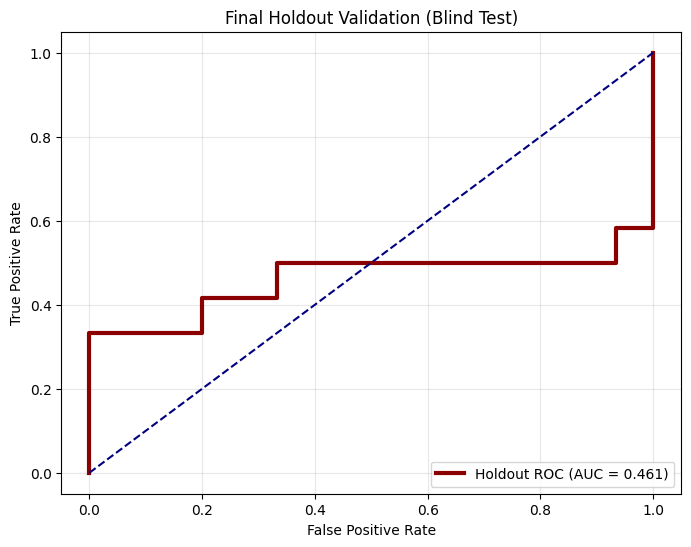

In [ ]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_holdout, probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkred', lw=3, label=f'Holdout ROC (AUC = {auc_score:.3f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final Holdout Validation (Blind Test)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.savefig("holdout_preprocessing/plots/holdout_final_roc_joblib.png")
print("Detailed results and plots saved in 'holdout_preprocessing/'.")

In [ ]:
# 5.5 DIAGNOSTIC: Check what's happening
print("="*80)
print("DIAGNOSTIC: Label & Prediction Analysis")
print("="*80)

preds = (probs > 0.5).astype(int)

print(f"\n1. Label Distribution:")
print(f"   0 (Healthy): {np.sum(y_holdout == 0)} samples")
print(f"   1 (Cancer):  {np.sum(y_holdout == 1)} samples")

print(f"\n2. Prediction Distribution:")
print(f"   0 (Predicted Healthy): {np.sum(preds == 0)} samples")
print(f"   1 (Predicted Cancer):  {np.sum(preds == 1)} samples")

print(f"\n3. Probability Statistics:")
print(f"   Min:    {probs.min():.4f}")
print(f"   Max:    {probs.max():.4f}")
print(f"   Mean:   {probs.mean():.4f}")
print(f"   Median: {np.median(probs):.4f}")

tn, fp, fn, tp = confusion_matrix(y_holdout, preds).ravel()
print(f"\n4. Confusion Matrix:")
print(f"   TP: {tp:2d}  FP: {fp:2d}")
print(f"   FN: {fn:2d}  TN: {tn:2d}")

print(f"\n5. Sample-by-Sample Breakdown:")
results_diag = pd.DataFrame({
    'sample': X_holdout.index,
    'group': group_info.loc[X_holdout.index, 'group'].values,
    'true_label': y_holdout,
    'prob_cancer': probs,
    'pred_label': preds
})
print(results_diag.sort_values('prob_cancer', ascending=False).to_string())

print(f"\n6. AUC Test - Check if labels are inverted:")
y_flipped = 1 - y_holdout
from sklearn.metrics import roc_auc_score
auc_flipped = roc_auc_score(y_flipped, probs)
print(f"   Current AUC:       {roc_auc_score(y_holdout, probs):.4f}")
print(f"   AUC with flipped labels: {auc_flipped:.4f}")
if auc_flipped > 0.8:
    print(f"   ⚠️  ALERT: Labels might be INVERTED! AUC improves to {auc_flipped:.4f}")

print("="*80)

DIAGNOSTIC: Label & Prediction Analysis

1. Label Distribution:
   0 (Healthy): 15 samples
   1 (Cancer):  12 samples

2. Prediction Distribution:
   0 (Predicted Healthy): 27 samples
   1 (Predicted Cancer):  0 samples

3. Probability Statistics:
   Min:    0.0000
   Max:    0.0000
   Mean:   0.0000
   Median: 0.0000

4. Confusion Matrix:
   TP:  0  FP:  0
   FN: 12  TN: 15

5. Sample-by-Sample Breakdown:
     sample       group  true_label   prob_cancer  pred_label
2   EE85726  colorectal           1  3.500266e-08           0
1   EE85724  colorectal           1  1.346783e-08           0
21  EE87786    bileduct           1  2.730529e-10           0
22  EE87787    bileduct           1  5.557153e-11           0
13  EE85842     healthy           0  2.932512e-11           0
7   EE85784     healthy           0  2.409640e-11           0
4   EE85757     healthy           0  2.299794e-11           0
24  EE87893     gastric           1  1.846001e-11           0
10  EE85795     healthy         

In [ ]:
df_holdout[df_holdout["group"] =="pancreatic"].head(10)

,sample,group,chrom,bin,mean,median,stdev,min,max,wps_value,start,end,GC,Extracted_ID,Study,bin_id
76680,EE86244,pancreatic,chr1,18,-52.536772,-68.877582,29.552008,-83.720090,-35.244043,-0.340843,900000,950000,0.63236,EE86244,Snyder,chr1_900000
76681,EE86244,pancreatic,chr1,21,-51.679908,-67.832049,48.079673,-87.741209,89.290264,-0.030760,1050000,1100000,0.62400,EE86244,Snyder,chr1_1050000
76682,EE86244,pancreatic,chr1,23,-52.055611,-57.832132,36.970801,-81.154249,37.725025,-0.177782,1150000,1200000,0.59202,EE86244,Snyder,chr1_1150000
76683,EE86244,pancreatic,chr1,25,-41.746422,-25.047657,33.066499,-93.800822,24.898563,-0.301250,1250000,1300000,0.60030,EE86244,Snyder,chr1_1250000
76684,EE86244,pancreatic,chr1,26,-55.373040,-56.334984,34.215444,-87.352922,41.813193,-0.191262,1300000,1350000,0.64590,EE86244,Snyder,chr1_1300000
76685,EE86244,pancreatic,chr1,27,-69.986529,-75.821288,26.205566,-86.877117,-10.156359,-0.086583,1350000,1400000,0.56750,EE86244,Snyder,chr1_1350000
76686,EE86244,pancreatic,chr1,28,-58.997191,-72.825214,34.624323,-85.867563,5.619796,-0.138155,1400000,1450000,0.57180,EE86244,Snyder,chr1_1400000
76687,EE86244,pancreatic,chr1,30,-57.510904,-67.537872,38.875985,-91.821729,36.370695,-0.020302,1500000,1550000,0.59168,EE86244,Snyder,chr1_1500000
76688,EE86244,pancreatic,chr1,32,-35.192249,-21.391114,37.606305,-90.786644,83.243235,-0.369352,1600000,1650000,0.60602,EE86244,Snyder,chr1_1600000
76689,EE86244,pancreatic,chr1,33,-26.352373,-7.726216,26.926289,-79.970824,-15.758183,-0.210268,1650000,1700000,0.52990,EE86244,Snyder,chr1_1650000


In [ ]:
df_holdout[df_holdout["group"] =="gastric"].head(10)

,sample,group,chrom,bin,mean,median,stdev,min,max,wps_value,start,end,GC,Extracted_ID,Study,bin_id
115020,EE87893,gastric,chr1,18,-6.881099,-2.089293,5.434772,-11.313918,13.706400,0.161312,900000,950000,0.63236,EE87893,Cristiano,chr1_900000
115021,EE87893,gastric,chr1,21,7.272104,5.321975,-3.286273,25.828271,13.371662,0.318584,1050000,1100000,0.62400,EE87893,Cristiano,chr1_1050000
115022,EE87893,gastric,chr1,23,-1.491974,-0.191251,-1.716257,7.039650,-10.609387,-0.043609,1150000,1200000,0.59202,EE87893,Cristiano,chr1_1150000
115023,EE87893,gastric,chr1,25,2.256382,-0.183802,1.558644,-0.268031,9.901472,-0.278027,1250000,1300000,0.60030,EE87893,Cristiano,chr1_1250000
115024,EE87893,gastric,chr1,26,-0.734360,-2.446706,-1.027363,-0.876539,-5.428572,0.284498,1300000,1350000,0.64590,EE87893,Cristiano,chr1_1300000
115025,EE87893,gastric,chr1,27,-1.231575,0.705636,4.694113,-17.209744,27.034865,0.003975,1350000,1400000,0.56750,EE87893,Cristiano,chr1_1350000
115026,EE87893,gastric,chr1,28,-2.082448,-3.747173,5.048379,-15.782725,-0.785966,0.207880,1400000,1450000,0.57180,EE87893,Cristiano,chr1_1400000
115027,EE87893,gastric,chr1,30,-3.973605,-10.028322,2.429622,2.378775,-9.956884,-0.089781,1500000,1550000,0.59168,EE87893,Cristiano,chr1_1500000
115028,EE87893,gastric,chr1,32,-6.536481,-6.871450,-1.046990,-4.865452,-14.362006,0.007660,1600000,1650000,0.60602,EE87893,Cristiano,chr1_1600000
115029,EE87893,gastric,chr1,33,-17.287277,-15.698592,3.365002,-23.581056,-25.566560,-0.512676,1650000,1700000,0.52990,EE87893,Cristiano,chr1_1650000


In [ ]:
df_holdout[df_holdout["group"] =="colorectal"].head(10)

,sample,group,chrom,bin,mean,median,stdev,min,max,wps_value,start,end,GC,Extracted_ID,Study,bin_id
0,EE85723,colorectal,chr1,18,-46.580324,-82.796373,25.153151,-98.742254,-43.540143,-0.284789,900000,950000,0.63236,EE85723,Sun,chr1_900000
1,EE85723,colorectal,chr1,21,-45.378134,-36.647236,-8.414379,-50.124136,-75.068506,-0.176880,1050000,1100000,0.62400,EE85723,Sun,chr1_1050000
2,EE85723,colorectal,chr1,23,-61.923549,-50.574831,10.134747,-97.644716,-69.503030,-0.240530,1150000,1200000,0.59202,EE85723,Sun,chr1_1150000
3,EE85723,colorectal,chr1,25,-36.953695,-29.312083,-4.036343,-42.061100,-63.352656,-0.175421,1250000,1300000,0.60030,EE85723,Sun,chr1_1250000
4,EE85723,colorectal,chr1,26,-63.493311,-56.083340,-0.235036,-80.034570,-79.376308,-0.292628,1300000,1350000,0.64590,EE85723,Sun,chr1_1300000
5,EE85723,colorectal,chr1,27,-52.093998,-45.926649,55.742074,-111.315196,-20.207501,-0.097489,1350000,1400000,0.56750,EE85723,Sun,chr1_1350000
6,EE85723,colorectal,chr1,28,-48.762071,-51.983032,25.876662,-104.631432,-37.442352,-0.296507,1400000,1450000,0.57180,EE85723,Sun,chr1_1400000
7,EE85723,colorectal,chr1,30,-32.859605,-39.942943,0.138181,-43.913164,-53.897181,-0.202094,1500000,1550000,0.59168,EE85723,Sun,chr1_1500000
8,EE85723,colorectal,chr1,32,-16.381568,-21.478478,-0.640642,-29.658298,-41.324223,-0.271928,1600000,1650000,0.60602,EE85723,Sun,chr1_1600000
9,EE85723,colorectal,chr1,33,-67.813061,-82.329231,27.088067,-122.138191,-65.868742,-0.071192,1650000,1700000,0.52990,EE85723,Sun,chr1_1650000


In [ ]:
print(df_holdout[["mean", "median", "stdev", "min", "max", "wps_value"]].mean())


mean        -10.216851
median       -9.403621
stdev         5.637795
min         -19.705031
max           3.729433
wps_value    -0.056907
dtype: float64


In [ ]:
df_holdout[df_holdout["group"] =="esophageal"].head(10)

,sample,group,chrom,bin,mean,median,stdev,min,max,wps_value,start,end,GC,Extracted_ID,Study,bin_id


In [ ]:
# --- FEATURE TREND ANALYSIS (In dein Validierungs-Skript einfügen) ---
print("\n" + "="*60)
print("FEATURE TREND ANALYSIS: Training (from Scaler) vs. Holdout")
print("="*60)

# 1. Hol dir die Koeffizienten und den Scaler aus der geladenen Pipeline
scaler = model.named_steps['scaler']
stable_model = model.named_steps['stable_model']
coeffs = stable_model.coef_[0]

# 2. Finde die Top 5 Features (stärkste Auswirkung auf die Entscheidung)
top_indices = np.argsort(np.abs(coeffs))[::-1][:5]
top_features = [model_features[i] for i in top_indices]

comparison_results = []

for idx in top_indices:
    feat_name = model_features[idx]
    
    # Trainings-Info: Der Scaler "weiß" noch den Mittelwert aus dem Training
    train_mean = scaler.mean_[idx]
    train_coeff = coeffs[idx]
    
    # Holdout-Info: Tatsächliche Werte in deinem aktuellen Datensatz
    h_healthy = X_holdout.loc[y_holdout == 0, feat_name].mean()
    h_cancer = X_holdout.loc[y_holdout == 1, feat_name].mean()
    h_trend = h_cancer - h_healthy  # Positiv, wenn Cancer > Healthy
    
    comparison_results.append({
        'Feature': feat_name,
        'Coeff (Train)': train_coeff,
        'Train_Mean_Total': train_mean,
        'Holdout_Healthy': h_healthy,
        'Holdout_Cancer': h_cancer,
        'Holdout_Trend': h_trend
    })

df_trends = pd.DataFrame(comparison_results)
print(df_trends.to_string(index=False))

# 3. Logik-Check für die Inversion
print("\n--- INVERSION CHECK ---")
for _, row in df_trends.iterrows():
    # Wenn Coeff > 0, erwartet das Modell: Cancer > Healthy
    # Wenn Coeff < 0, erwartet das Modell: Cancer < Healthy
    expected_positive_trend = row['Coeff (Train)'] > 0
    actual_positive_trend = row['Holdout_Trend'] > 0
    
    if expected_positive_trend != actual_positive_trend:
        print(f"⚠️  INVERSION in {row['Feature']}:")
        print(f"   Model expects {'INCREASE' if expected_positive_trend else 'DECREASE'} for Cancer.")
        print(f"   Data shows {'INCREASE' if actual_positive_trend else 'DECREASE'} in Holdout.")
    else:
        print(f"✅ Trend for {row['Feature']} is consistent with training logic.")
        


FEATURE TREND ANALYSIS: Training (from Scaler) vs. Holdout
              Feature  Coeff (Train)  Train_Mean_Total  Holdout_Healthy  Holdout_Cancer  Holdout_Trend
 stdev_chr1_144150000      -0.652111        -20.854939       -18.929270      -19.131562      -0.202292
median_chr1_158450000      -0.556481          1.133904         3.131317      -18.018144     -21.149461
median_chr5_175650000       0.540607          0.322531         1.484364      -25.696536     -27.180899
median_chr11_60850000       0.494234          1.350903         2.359156      -21.210432     -23.569588
 median_chr9_87450000       0.457729          0.712076         1.343036      -20.979403     -22.322439

--- INVERSION CHECK ---
✅ Trend for stdev_chr1_144150000 is consistent with training logic.
✅ Trend for median_chr1_158450000 is consistent with training logic.
⚠️  INVERSION in median_chr5_175650000:
   Model expects INCREASE for Cancer.
   Data shows DECREASE in Holdout.
⚠️  INVERSION in median_chr11_60850000:
   Mode

In [ ]:
import pandas as pd
from sklearn.metrics import roc_auc_score

# 1. Studien-Informationen laden
study_info_path = "/labmed/workspace/lotta/finaletoolkit/ba_analysis_scripts/holdout_preprocessing/dataframes_holdout/study_matrix_holdout.csv"
df_study = pd.read_csv(study_info_path, sep=";")
df_study = df_study.set_index('Extracted_ID')

# 2. DataFrame für die Analyse bauen
# Wir stellen sicher, dass die Indizes (Sample IDs) übereinstimmen
analysis_df = pd.DataFrame({
    'sample': X_holdout.index,
    'true_label': y_holdout,
    'prob_cancer': probs
}).set_index('sample')

# Studie hinzufügen
analysis_df['study'] = df_study.loc[analysis_df.index, 'Study']

print("=== AUC-Analyse pro Studie (Holdout) ===")
print("-" * 50)

for study, data in analysis_df.groupby('study'):
    n_total = len(data)
    n_healthy = sum(data['true_label'] == 0)
    n_cancer = sum(data['true_label'] == 1)
    
    if n_healthy > 0 and n_cancer > 0:
        auc = roc_auc_score(data['true_label'], data['prob_cancer'])
        print(f"Studie: {study:12} | AUC: {auc:.4f} | n={n_total} (H:{n_healthy}, C:{n_cancer})")
    else:
        # In Jiang sind z.B. nur Healthy Proben, da kann man keinen AUC berechnen
        avg_prob = data['prob_cancer'].mean()
        print(f"Studie: {study:12} | AUC: N/A (nur 1 Klasse) | n={n_total} | Avg Prob: {avg_prob:.2e}")

print("-" * 50)
print("\n=== Vergleich der Durchschnitts-Scores ===")
# Hier sehen wir, ob eine Studie generell viel höhere/niedrigere Scores liefert als andere
study_summary = analysis_df.groupby(['study', 'true_label'])['prob_cancer'].mean().unstack()
study_summary.columns = ['Mean Prob (Healthy)', 'Mean Prob (Cancer)']
print(study_summary)


=== AUC-Analyse pro Studie (Holdout) ===
--------------------------------------------------
Studie: Cristiano    | AUC: N/A (nur 1 Klasse) | n=6 | Avg Prob: 5.98e-11
Studie: Jiang        | AUC: N/A (nur 1 Klasse) | n=15 | Avg Prob: 8.44e-12
Studie: Snyder       | AUC: N/A (nur 1 Klasse) | n=3 | Avg Prob: 2.22e-16
Studie: Sun          | AUC: N/A (nur 1 Klasse) | n=3 | Avg Prob: 1.62e-08
--------------------------------------------------

=== Vergleich der Durchschnitts-Scores ===
           Mean Prob (Healthy)  Mean Prob (Cancer)
study                                             
Cristiano                  NaN        5.975252e-11
Jiang             8.442298e-12                 NaN
Snyder                     NaN        2.223370e-16
Sun                        NaN        1.615683e-08
